# Classifying Playing Cards
The purpose of this notebook is to build several neural networks, train them and compare architecture to classify images of cards

## Importing Packages and Functions

In [1]:
import numpy as np
import os 
import PIL
import PIL.Image 
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

In [1]:
def image_prediction(image_path, model, class_names, img_width=224, img_height=224):
    """
    For a given image outputs the predicted class
    """
    image = PIL.Image.open(image_path).resize((img_width, img_height)).convert('RGB')
    image_array = np.array(image) / 255  # Scale pixel values to -1 to 1
    image_array = np.expand_dims(image_array, axis=0)  # Add a batch dimension

    predictions = model.predict(image_array)
    
    # Since the model's final layer uses a softmax activation, predictions are already in probability form
    predicted_class = np.argmax(predictions[0])  # Get the index of the highest probability class
    probability = predictions[0][predicted_class]  # Get the probability of the predicted class
    
    print(f"Predicted class: {predicted_class}, Probability: {probability}, Class: {class_names[predicted_class]}")
    return class_names[predicted_class]

In [159]:
def holdout_set(model):
    """
    Test a model against the holdout set 
    """
    total = 0 
    correct = 0 
    test_dir = "D:/card_data/cv_num_cards_deck/test_images/"
    predics = []
    for card in os.listdir(test_dir):
        card_path = os.path.join(test_dir, card)
        images = os.listdir(card_path)
        for image in images:
            total += 1
            image_path = os.path.join(card_path, image)
            predict = image_prediction(image_path, model, class_names)
            if card == predict:
                correct += 1

            
            predics.append((card, predict))
    print(predics)
    print(f"overall accuracy is {round((correct/total)*100, 2)}%. So {correct} correct out of {total}")

## Importing the data from directory 

In [2]:
local_data_dir = 'D:/card_data/cv_num_cards_deck/52kards'

In [3]:
# classes = os.listdir(local_data_dir)
# fig, axs = plt.subplots(len(classes), 1, figsize=(5, 5 * len(classes)))

# for i, class_name in enumerate(classes):
#     class_dir = os.path.join(local_data_dir, class_name)
#     sample_image_path = os.path.join(class_dir, os.listdir(class_dir)[0])  # Take the first image
#     img = PIL.Image.open(sample_image_path)
#     axs[i].imshow(img)
#     axs[i].set_title(class_name)
#     axs[i].axis('off')

# plt.show()

In [4]:
img_height = 224
img_width = 224
img_size = (224, 224)
batch_size = 32

In [5]:
# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    local_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width), # specified the resizing 
    batch_size=batch_size) 

Found 12304 files belonging to 52 classes.
Using 9844 files for training.


In [6]:
# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    local_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 12304 files belonging to 52 classes.
Using 2460 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']


In [8]:
# visualize the first 9 images from the dataset
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [9]:
# image preprocessing 
normalization_layer = tf.keras.layers.Rescaling(1./255) # 1./127.5, offset=-1
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
augmented_ds = normalized_ds # .map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# naming hasn't changed because of laziness 

In [10]:
# need comments
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training our own Neural Network (not appropriate for classification with more classes - defunct)
We're first going to try training our own convolutional neural network from scratch 


In [11]:
num_classes = 52

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(52, activation='softmax')
])

In [12]:
model_1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [36]:
model_1.fit(
  normalized_ds, # augmented_ds
  validation_data=val_ds,
  epochs=10
)   # so far best at 8 epochs and 20 

Epoch 1/10
308/308 [==============================] - 12s 39ms/step - loss: 0.1054 - accuracy: 0.9665 - val_loss: 0.2732 - val_accuracy: 0.9126
Epoch 2/10
308/308 [==============================] - 11s 37ms/step - loss: 0.1109 - accuracy: 0.9621 - val_loss: 0.2645 - val_accuracy: 0.9122
Epoch 3/10
308/308 [==============================] - 12s 38ms/step - loss: 0.0957 - accuracy: 0.9677 - val_loss: 0.3135 - val_accuracy: 0.9102
Epoch 4/10
308/308 [==============================] - 12s 39ms/step - loss: 0.0939 - accuracy: 0.9688 - val_loss: 0.2189 - val_accuracy: 0.9325
Epoch 5/10
308/308 [==============================] - 12s 39ms/step - loss: 0.0780 - accuracy: 0.9741 - val_loss: 0.2363 - val_accuracy: 0.9224
Epoch 6/10
308/308 [==============================] - 12s 38ms/step - loss: 0.0839 - accuracy: 0.9732 - val_loss: 0.2104 - val_accuracy: 0.9354
Epoch 7/10
308/308 [==============================] - 11s 37ms/step - loss: 0.0682 - accuracy: 0.9773 - val_loss: 0.2202 - val_accuracy:

In [174]:
holdout_set(model_1)

1/1 [==============================] - 0s 17ms/step
Predicted class: 0, Probability: 0.9999791383743286, Class: 10c
1/1 [==============================] - 0s 18ms/step
Predicted class: 44, Probability: 0.6086766719818115, Class: Kc
1/1 [==============================] - 0s 17ms/step
Predicted class: 4, Probability: 0.8837106227874756, Class: 2c
1/1 [==============================] - 0s 17ms/step
Predicted class: 4, Probability: 0.9999974966049194, Class: 2c
1/1 [==============================] - 0s 17ms/step
Predicted class: 4, Probability: 0.7461322546005249, Class: 2c
1/1 [==============================] - 0s 18ms/step
Predicted class: 12, Probability: 0.9243260025978088, Class: 4c
1/1 [==============================] - 0s 18ms/step
Predicted class: 4, Probability: 0.7419008612632751, Class: 2c
1/1 [==============================] - 0s 18ms/step
Predicted class: 7, Probability: 0.5424512624740601, Class: 2s
1/1 [==============================] - 0s 16ms/step
Predicted class: 12, Prob

In [27]:
os.listdir("D:/card_data/cv_num_cards_deck/test_images/2c/")

['Image20240325150113.png', 'IMG_E0924.JPG']

## Assessing predictions from our model

Our model is assessing all three classes as the same class with very similar probability.

# Model 2 

In [42]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(52, activation='softmax')
])

model_2.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [49]:
model_2.fit(
  normalized_ds, # augmented_ds
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
308/308 [==============================] - 17s 54ms/step - loss: 0.0579 - accuracy: 0.9836 - val_loss: 0.3498 - val_accuracy: 0.9313
Epoch 2/10
308/308 [==============================] - 17s 54ms/step - loss: 0.0503 - accuracy: 0.9865 - val_loss: 0.3140 - val_accuracy: 0.9419
Epoch 3/10
308/308 [==============================] - 17s 53ms/step - loss: 0.0485 - accuracy: 0.9870 - val_loss: 0.3836 - val_accuracy: 0.9309
Epoch 4/10
308/308 [==============================] - 17s 54ms/step - loss: 0.0625 - accuracy: 0.9872 - val_loss: 0.4200 - val_accuracy: 0.9256
Epoch 5/10
308/308 [==============================] - 17s 54ms/step - loss: 0.0467 - accuracy: 0.9880 - val_loss: 0.4049 - val_accuracy: 0.9236
Epoch 6/10
308/308 [==============================] - 17s 54ms/step - loss: 0.0475 - accuracy: 0.9875 - val_loss: 0.4382 - val_accuracy: 0.9289
Epoch 7/10
308/308 [==============================] - 17s 54ms/step - loss: 0.0675 - accuracy: 0.9873 - val_loss: 0.3038 - val_accuracy:

In [175]:
holdout_set(model_2)

1/1 [==============================] - 0s 17ms/step
Predicted class: 0, Probability: 1.0, Class: 10c
1/1 [==============================] - 0s 19ms/step
Predicted class: 32, Probability: 0.7560040354728699, Class: 9c
1/1 [==============================] - 0s 17ms/step
Predicted class: 7, Probability: 0.9954337477684021, Class: 2s
1/1 [==============================] - 0s 18ms/step
Predicted class: 4, Probability: 0.9999998807907104, Class: 2c
1/1 [==============================] - 0s 18ms/step
Predicted class: 4, Probability: 0.7679769992828369, Class: 2c
1/1 [==============================] - 0s 17ms/step
Predicted class: 15, Probability: 0.9234055280685425, Class: 4s
1/1 [==============================] - 0s 19ms/step
Predicted class: 15, Probability: 0.9930164813995361, Class: 4s
1/1 [==============================] - 0s 19ms/step
Predicted class: 4, Probability: 0.9274234175682068, Class: 2c
1/1 [==============================] - 0s 18ms/step
Predicted class: 15, Probability: 0.997

In [20]:
# model_OG = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(52, activation='softmax')
# ])

# Visualizing the Feature Maps (the affects of filters in the 2d layers)

In [58]:
def image_prepro(path):
    image = PIL.Image.open(image_path).resize((img_width, img_height)).convert('RGB')
    image_array = np.array(image) / 255  # Scale pixel values to -1 to 1
    image_array = np.expand_dims(image_array, axis=0)  # Add a batch dimension
    return image_array

In [59]:
test_image = image_prepro("D:/card_data/cv_num_cards_deck/test_images/5h/IMG_0929.JPG")

In [115]:
selected_layers = [
    model_1.layers[0].output,  # First Conv2D layer output
    model_1.layers[1].output,  # First MaxPooling2D layer output
    model_1.layers[2].output,  # Second Conv2D layer output
    model_1.layers[3].output,  # Second Maxpooling2D layer output
    model_1.layers[4].output,  # Third Conv2D layer output
    model_1.layers[5].output,  # Maxpooling2d layer output 
    model_1.layers[6].output,  # Fourth Conv2D layer 
    model_1.layers[7].output   # maxpooling2d layer 
]

model_intermediate = tf.keras.models.Model(inputs=model_1.input, outputs=selected_layers)
feature_maps = model_intermediate.predict(test_image)

1/1 [==============================] - 0s 74ms/step


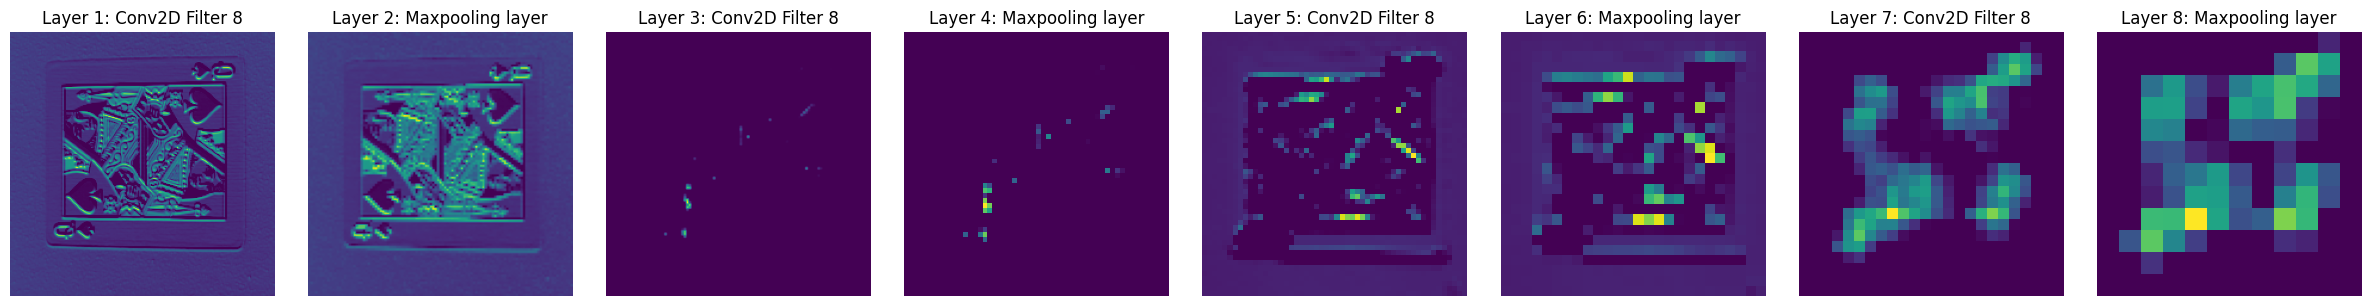

In [137]:
# Assuming `feature_maps` is obtained from model_intermediate.predict(test_image)
n_layers = len(feature_maps)

# Choose a specific filter to follow; starting with the first filter as an example
filter_index = 8

# Set the number of rows and columns for subplot visualization
n_rows = 1
n_cols = n_layers

# Create a figure to visualize the feature maps
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# If there's only one layer to visualize, ensure `axes` is iterable
if n_layers == 1:
    axes = [axes]

# Loop through each layer's feature map
for col, feature_map in enumerate(feature_maps):
    # Normalize the selected feature map for better visualization
    fm = feature_map[0, :, :, filter_index]  # Assuming a batch size of 1, select the filter_index-th filter
    fm_normalized = (fm - fm.min()) / (fm.max() - fm.min()) if fm.max() > fm.min() else fm

    ax = axes[col]
    ax.imshow(fm_normalized, cmap='viridis')
    if (col + 1) % 2 == 1:
        ax.set_title(f'Layer {col+1}: Conv2D Filter {filter_index}')
    else:
        ax.set_title(f'Layer {col+1}: Maxpooling layer')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model_3 

In [101]:
num_classes = 52

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(52, activation='softmax')
])
model_3.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [106]:
model_3.fit(
  normalized_ds, # augmented_ds
  validation_data=val_ds,
  epochs= 2
) 

Epoch 1/2
308/308 [==============================] - 12s 37ms/step - loss: 0.0455 - accuracy: 0.9868 - val_loss: 0.0800 - val_accuracy: 0.9752
Epoch 2/2
308/308 [==============================] - 11s 36ms/step - loss: 0.0400 - accuracy: 0.9869 - val_loss: 0.0782 - val_accuracy: 0.9793


In [185]:
model_3.save('models/model_to_use')

INFO:tensorflow:Assets written to: models/model_to_use\assets


INFO:tensorflow:Assets written to: models/model_to_use\assets


In [183]:
holdout_set(model_3)

1/1 [==============================] - 0s 18ms/step
Predicted class: 0, Probability: 1.0, Class: 10c
1/1 [==============================] - 0s 17ms/step
Predicted class: 4, Probability: 0.9884916543960571, Class: 2c
1/1 [==============================] - 0s 18ms/step
Predicted class: 4, Probability: 0.9999992847442627, Class: 2c
1/1 [==============================] - 0s 18ms/step
Predicted class: 11, Probability: 1.0, Class: 3s
1/1 [==============================] - 0s 17ms/step
Predicted class: 12, Probability: 1.0, Class: 4c
1/1 [==============================] - 0s 18ms/step
Predicted class: 15, Probability: 0.9998482465744019, Class: 4s
1/1 [==============================] - 0s 19ms/step
Predicted class: 18, Probability: 0.9997039437294006, Class: 5h
1/1 [==============================] - 0s 19ms/step
Predicted class: 18, Probability: 0.9975417852401733, Class: 5h
1/1 [==============================] - 0s 17ms/step
Predicted class: 21, Probability: 0.9999845027923584, Class: 6d
1/1

In [184]:
model_3.save('models/my_model.h5')

In [172]:
selected_layers_m3 = [
    model_3.layers[0].output,  # First Conv2D layer output
    model_3.layers[1].output,  # First MaxPooling2D layer output
    model_3.layers[2].output,  # Second Conv2D layer output
    model_3.layers[3].output,  # Second Maxpooling2D layer output
    model_3.layers[4].output,  # Third Conv2D layer output
    model_3.layers[5].output,  # Maxpooling2d layer output 
    model_3.layers[6].output,  # Fourth Conv2D layer 
    model_3.layers[7].output,  # maxpooling2d layer
    model_3.layers[8].output   # Last/fifth Conv2D layer
]

model_intermediate = tf.keras.models.Model(inputs=model_3.input, outputs=selected_layers_m3)
feature_maps_m3 = model_intermediate.predict(test_image)

1/1 [==============================] - 0s 64ms/step


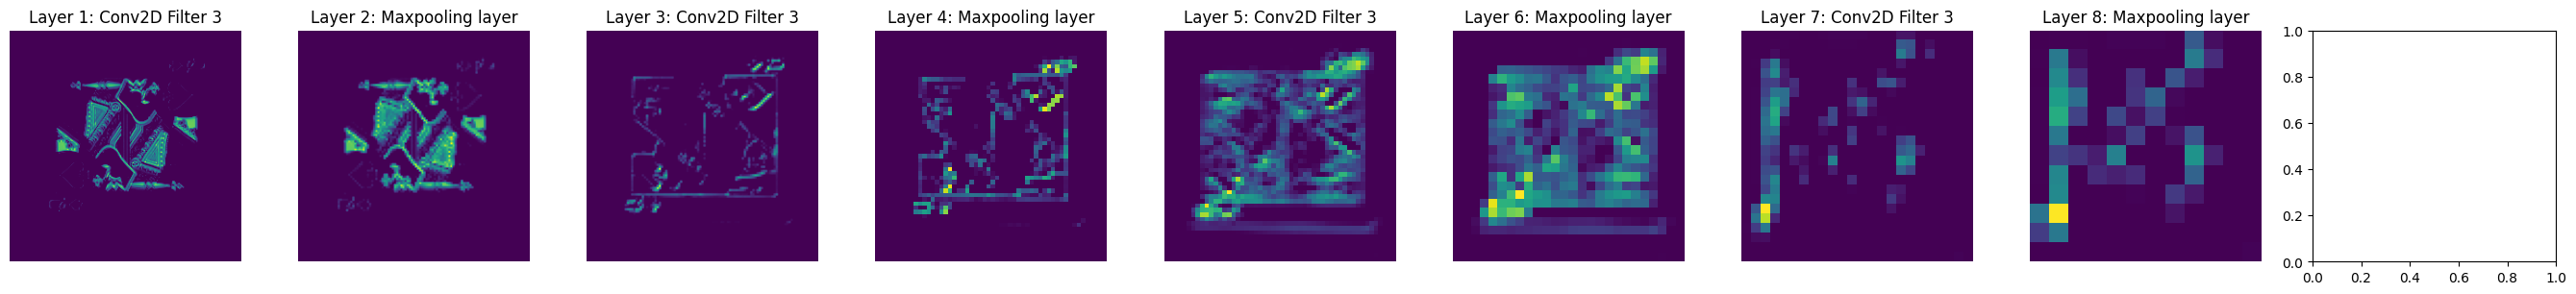

In [173]:
# Assuming `feature_maps` is obtained from model_intermediate.predict(test_image)
n_layers = len(feature_maps_m3)

# Choose a specific filter to follow; starting with the first filter as an example
filter_index = 3

# Set the number of rows and columns for subplot visualization
n_rows = 1
n_cols = n_layers

# Create a figure to visualize the feature maps
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# If there's only one layer to visualize, ensure `axes` is iterable
if n_layers == 1:
    axes = [axes]

# Loop through each layer's feature map
for col, feature_map in enumerate(feature_maps):
    # Normalize the selected feature map for better visualization
    fm = feature_map[0, :, :, filter_index]  # Assuming a batch size of 1, select the filter_index-th filter
    fm_normalized = (fm - fm.min()) / (fm.max() - fm.min()) if fm.max() > fm.min() else fm

    ax = axes[col]
    ax.imshow(fm_normalized, cmap='viridis')
    if (col + 1) % 2 == 1:
        ax.set_title(f'Layer {col+1}: Conv2D Filter {filter_index}')
    else:
        ax.set_title(f'Layer {col+1}: Maxpooling layer')
    ax.axis('off')

plt.tight_layout()
plt.show()